In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process DTI and free water DTI
import dipy.reconst.dti as dti
import dipy.reconst.fwdti as fwdti

In [2]:
SNR = 15

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts), 1500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
gtab = gradient_table(bvals, bvecs)

In [6]:
# free water component
VF = np.linspace(0, 100, num=11)
Dwater = 3e-3

# axonal water fraction relative to tissue volume fraction
AWF = np.linspace(0.3, 0.7, num=5)

# Hindered and restricted diffusion values
ADr = 0.99e-3
RDr = 0.00e-3
ADh = 2.26e-3 
RDh = 0.87e-3

mevals = np.array([[Dwater, Dwater, Dwater],
                   [ADr, RDr, RDr],
                   [ADh, RDh, RDh]])

# simulations are repeated for 120 different diffusion tensor's
# directions (and each direction repeated 100 times)
nDTdirs = 120
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices # directions for each shell

nrep = 100  # number of repetitions for each direction

In [22]:
# Generate ground truth
DWI_gt = np.empty((AWF.size, bvals.size))

count_i = 0.0
for awf_i in range(AWF.size):
    fractions = [0.0, 100 * AWF[awf_i], 100 * (1-AWF[awf_i])]
    signal, sticks = multi_tensor(gtab, mevals, S0=100,
                                  angles=[(1.0, 0.0, 0.0),
                                          (1.0, 0.0, 0.0),
                                          (1.0, 0.0, 0.0)],
                                  fractions=fractions,
                                  snr=None)
    DWI_gt[awf_i] = signal
dtimodel = dti.TensorModel(gtab, fit_method="NLLS")
dtifit = dtimodel.fit(DWI_gt)
FAgt = dtifit.fa
MDgt = dtifit.md
print FAgt
print MDgt

[ 0.67352287  0.7198121   0.76724804  0.81537738  0.86351836]
[ 0.00086471  0.00075112  0.0006541   0.00057069  0.00049839]


In [9]:
DWI_simulates = np.empty((AWF.size, VF.size, nrep * nDTdirs,
                          bvals.size))

count_i = 0.0
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        fractions = [VF[vf_i], (100-VF[vf_i]) * AWF[awf_i],
                     (100-VF[vf_i]) * (1-AWF[awf_i])]
        for di in range(nDTdirs):
            d = DTdirs[di]
            for s_i in np.arange(di * nrep, (di+1) * nrep):
                signal, sticks = multi_tensor(gtab, mevals,
                                              S0=100,
                                              angles=[d, d, d],
                                              fractions=fractions,
                                              snr=SNR)
                DWI_simulates[awf_i, vf_i, s_i, :] = signal
        count_i = count_i + 1.0
        prog = (count_i) / (AWF.size * VF.size) * 100
        time.sleep(1)
        sys.stdout.write("\r%f%%" % prog)
        sys.stdout.flush()

100.000000%

In [26]:
t0 = time.time()
dtimodel = dti.TensorModel(gtab, fit_method="NLLS")
dtifit = dtimodel.fit(DWI_simulates)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 289.336000 seconds to run


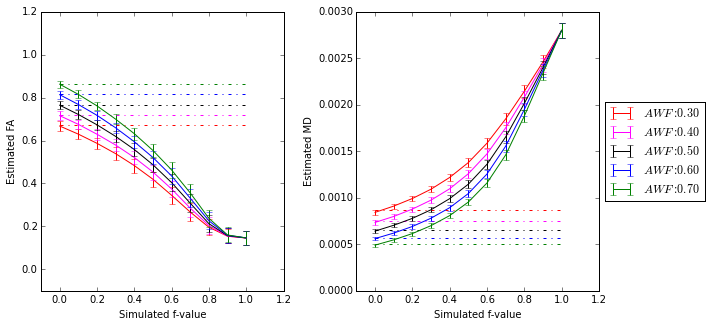

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)

fa = dtifit.fa
md = dtifit.md

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

median_md = np.empty(VF.size)
md_lower_p = np.empty(VF.size)
md_upper_p = np.empty(VF.size)

colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

axs[0].set_ylim([-0.1, 1.2])
axs[0].set_xlim([-0.1, 1.2])
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[awf_i, vf_i, :])
        p25, p75 = np.percentile(fa[awf_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        upper_p[vf_i] = p75 - median_fa[vf_i]
    axs[0].plot(np.array([0., 1.]), FAgt[awf_i]*np.ones(2),
                ls='-.', c=colors[awf_i])
    axs[0].errorbar(VF/100, median_fa, fmt='-',
                    yerr=[lower_p, upper_p],
                    color=colors[awf_i],
                    ecolor=colors[awf_i],
                    linewidth=1.0,
                    label='$AWF: %.2f$' % AWF[awf_i])
axs[0].set_xlabel('Simulated f-value')
axs[0].set_ylabel('Estimated FA')

#axs[1].set_ylim([-0.1, 1.2])
axs[1].set_xlim([-0.1, 1.2])
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        median_md[vf_i] = np.median(md[awf_i, vf_i, :])
        p25, p75 = np.percentile(md[awf_i, vf_i, :], [25 ,75])
        md_lower_p[vf_i] = median_md[vf_i] - p25 
        md_upper_p[vf_i] = p75 - median_md[vf_i]
    axs[1].plot(np.array([0., 1.]), MDgt[awf_i]*np.ones(2),
                ls='-.', c=colors[awf_i])
    axs[1].errorbar(VF/100, median_md, fmt='-',
                    yerr=[md_lower_p, md_upper_p],
                    color=colors[awf_i],
                    ecolor=colors[awf_i],
                    linewidth=1.0,
                    label='$AWF: %.2f$' % AWF[awf_i])
axs[1].set_xlabel('Simulated f-value')
axs[1].set_ylabel('Estimated MD')

axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('dtiFA_vs_freewatercontamination_snr15_tissue_model.png', dpi=500)

In [32]:
t0 = time.time()
fwdtimodel = fwdti.FreeWaterTensorModel(gtab, fit_method="WLS")
fwdtifit = fwdtimodel.fit(DWI_simulates)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

This step took 698.280000 seconds to run


fa values
[ 0.03555635  0.03436203  0.03260858  0.03403701  0.03241292  0.03174619
  0.03468412  0.05186987  0.06138891  0.05313368  0.0792749 ]
[ 0.04163142  0.04061942  0.04040139  0.03849284  0.03908977  0.03551836
  0.0369159   0.04012089  0.03558854  0.00938378  0.03499779]
[ 0.04364165  0.04369435  0.04295911  0.04235964  0.04138722  0.03901108
  0.03382045  0.03512303  0.01736269 -0.02685617 -0.01124732]
[ 0.04017486  0.04137856  0.04189743  0.03998431  0.03759481  0.03641379
  0.03036459  0.0225941  -0.00566047 -0.07236343 -0.05984305]
[ 0.03409947  0.03477721  0.0351608   0.03407989  0.03199453  0.02922376
  0.01910736  0.00665467 -0.0276916  -0.10930872 -0.10892828]
md values
[-0.67282508 -0.67283557 -0.67284847 -0.67286439 -0.67288105 -0.67290217
 -0.67292707 -0.67294407 -0.67289284 -0.67255178 -0.67183052]
[-0.71920113 -0.71920991 -0.71921939 -0.71923135 -0.71924858 -0.71926307
 -0.7192825  -0.71929514 -0.71924475 -0.7189012  -0.71810578]
[-0.76670915 -0.7667162  -0.7667251

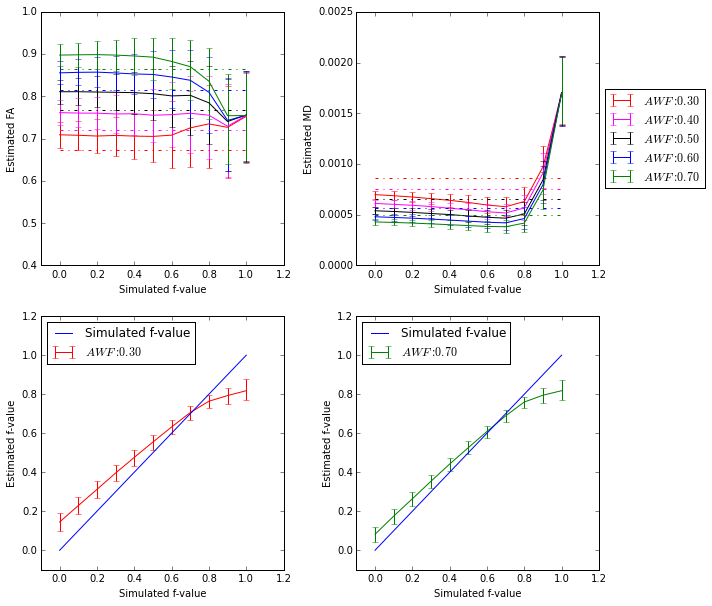

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.3)

f = fwdtifit.f
fa = fwdtifit.fa
md = fwdtifit.md

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

median_md = np.empty(VF.size)
md_lower_p = np.empty(VF.size)
md_upper_p = np.empty(VF.size)

print('fa values')

colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

axs[0, 0].set_ylim([0.4, 1])
axs[0, 0].set_xlim([-0.1, 1.2])
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[awf_i, vf_i, :])
        p25, p75 = np.percentile(fa[awf_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        upper_p[vf_i] = p75 - median_fa[vf_i]
    print median_fa - FAgt[awf_i]
    axs[0, 0].plot(np.array([0., 1.]), FAgt[awf_i]*np.ones(2),
                   ls='-.', c=colors[awf_i])
    axs[0, 0].errorbar(VF/100, median_fa, fmt='-',
                       yerr=[lower_p, upper_p],
                       color=colors[awf_i],
                       ecolor=colors[awf_i],
                       linewidth=1.0,
                       label='$AWF: %.2f$' % AWF[awf_i])
axs[0, 0].set_xlabel('Simulated f-value')
axs[0, 0].set_ylabel('Estimated FA')

print('md values')

#axs[1].set_ylim([-0.1, 1.2])
axs[0, 1].set_xlim([-0.1, 1.2])
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        median_md[vf_i] = np.median(md[awf_i, vf_i, :])
        p25, p75 = np.percentile(md[awf_i, vf_i, :], [25 ,75])
        md_lower_p[vf_i] = median_md[vf_i] - p25 
        md_upper_p[vf_i] = p75 - median_md[vf_i]
    axs[0, 1].plot(np.array([0., 1.]), MDgt[awf_i]*np.ones(2),
                   ls='-.', c=colors[awf_i])
    
    print median_md - FAgt[awf_i]
    axs[0, 1].errorbar(VF/100, median_md, fmt='-',
                       yerr=[md_lower_p, md_upper_p],
                       color=colors[awf_i],
                       ecolor=colors[awf_i],
                       linewidth=1.0,
                       label='$AWF: %.2f$' % AWF[awf_i])
axs[0, 1].set_xlabel('Simulated f-value')
axs[0, 1].set_ylabel('Estimated MD')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

print('f values')

median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

for idx, awf_i in enumerate([0, 4]):
    for vf_i in range(VF.size):
        median_f[vf_i] = np.median(f[awf_i, vf_i, :])
        p25, p75 = np.percentile(f[awf_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        upper_p[vf_i] = p75 - median_f[vf_i]
    axs[1, idx].errorbar(VF/100, median_f, fmt='-',
                      yerr=[lower_p, upper_p],
                      color=colors[awf_i],
                      ecolor=colors[awf_i],
                      linewidth=1.0,
                      label='$AWF: %.2f$' % AWF[awf_i])
    print median_f
    # plot ground truth lines
    axs[1, idx].plot([0, 1], [0, 1], 'b', label = 'Simulated f-value')
    axs[1, idx].legend(loc='upper left')
    axs[1, idx].set_ylim([-0.1, 1.2])
    axs[1, idx].set_xlim([-0.1, 1.2])
    axs[1, idx].set_xlabel('Simulated f-value')
    axs[1, idx].set_ylabel('Estimated f-value')

fig.savefig('fwdti_simulations_wls_snr15_tissue_model.png', dpi=500)

In [39]:
t0 = time.time()
fwdtimodel = fwdti.FreeWaterTensorModel(gtab)
fwdtifit = fwdtimodel.fit(DWI_simulates)
dt = time.time() - t0
print("This step took %f seconds to run" % dt)

C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)
C:\Users\Rafael\dipy\dipy\reconst\fwdti.py:453: RuntimeWarning: overflow encountered in exp
  y = (1-f) * np.exp(np.dot(design_matrix, tensor[:7])) + \


This step took 3300.965000 seconds to run


fa values
[ 0.04921362  0.04898704  0.04885886  0.05159776  0.05169574  0.05668953
  0.06689708  0.10355266  0.18351038  0.10874868 -0.67352287]
[ 0.05193348  0.05204909  0.05233746  0.0524029   0.05596858  0.05816652
  0.06766805  0.09181352  0.14650605  0.14734083 -0.7198121 ]
[ 0.05097388  0.05197994  0.05178153  0.05290516  0.0543165   0.057633
  0.0637702   0.08546599  0.11936829  0.13809125 -0.76724804]
[ 0.045386    0.04690488  0.04777784  0.04742801  0.04828089  0.05226152
  0.0558998   0.06595273  0.08782902  0.12703318 -0.81537738]
[ 0.03779434  0.03831709  0.03889375  0.03877458  0.03978167  0.04114738
  0.0412236   0.04639151  0.05838865  0.09380771 -0.86351836]
md values
[-0.67277522 -0.67278264 -0.67279189 -0.67280604 -0.67282554 -0.67286096
 -0.67291865 -0.67302763 -0.67322735 -0.67350281 -0.67352287]
[-0.71916284 -0.71916759 -0.71917361 -0.7191824  -0.71920178 -0.71922455
 -0.71926824 -0.71935316 -0.71951197 -0.7197743  -0.7198121 ]
[-0.76667978 -0.76668256 -0.76668738 

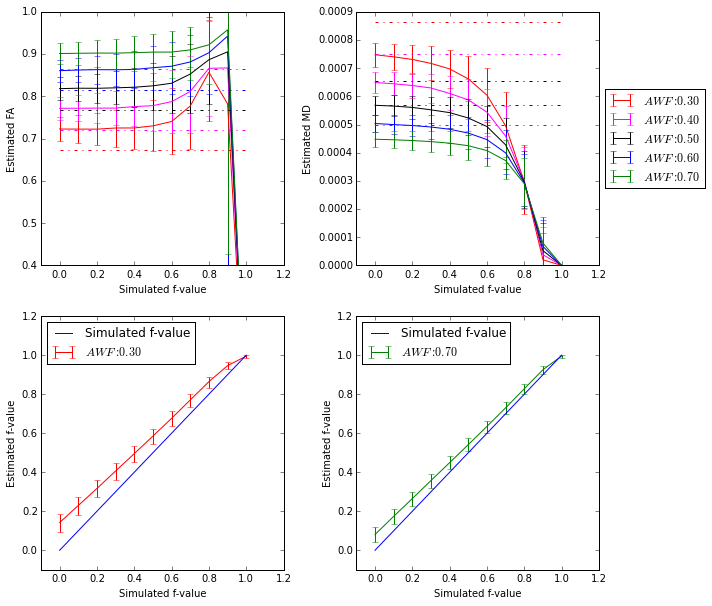

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.3)

f = fwdtifit.f
fa = fwdtifit.fa
md = fwdtifit.md

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

median_md = np.empty(VF.size)
md_lower_p = np.empty(VF.size)
md_upper_p = np.empty(VF.size)

print('fa values')

colors = {0: 'r', 1: 'magenta', 2: 'black', 3: 'b', 4: 'g'}

axs[0, 0].set_ylim([0.4, 1])
axs[0, 0].set_xlim([-0.1, 1.2])
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[awf_i, vf_i, :])
        p25, p75 = np.percentile(fa[awf_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        upper_p[vf_i] = p75 - median_fa[vf_i]
    print median_fa - FAgt[awf_i]
    axs[0, 0].plot(np.array([0., 1.]), FAgt[awf_i]*np.ones(2),
                   ls='-.', c=colors[awf_i])
    axs[0, 0].errorbar(VF/100, median_fa, fmt='-',
                       yerr=[lower_p, upper_p],
                       color=colors[awf_i],
                       ecolor=colors[awf_i],
                       linewidth=1.0,
                       label='$AWF: %.2f$' % AWF[awf_i])
axs[0, 0].set_xlabel('Simulated f-value')
axs[0, 0].set_ylabel('Estimated FA')

print('md values')

#axs[1].set_ylim([-0.1, 1.2])
axs[0, 1].set_xlim([-0.1, 1.2])
for awf_i in range(AWF.size):
    for vf_i in range(VF.size):
        median_md[vf_i] = np.median(md[awf_i, vf_i, :])
        p25, p75 = np.percentile(md[awf_i, vf_i, :], [25 ,75])
        md_lower_p[vf_i] = median_md[vf_i] - p25 
        md_upper_p[vf_i] = p75 - median_md[vf_i]
    axs[0, 1].plot(np.array([0., 1.]), MDgt[awf_i]*np.ones(2),
                   ls='-.', c=colors[awf_i])
    
    print median_md - FAgt[awf_i]
    axs[0, 1].errorbar(VF/100, median_md, fmt='-',
                       yerr=[md_lower_p, md_upper_p],
                       color=colors[awf_i],
                       ecolor=colors[awf_i],
                       linewidth=1.0,
                       label='$AWF: %.2f$' % AWF[awf_i])
axs[0, 1].set_xlabel('Simulated f-value')
axs[0, 1].set_ylabel('Estimated MD')

axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

print('f values')

median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

for idx, awf_i in enumerate([0, 4]):
    for vf_i in range(VF.size):
        median_f[vf_i] = np.median(f[awf_i, vf_i, :])
        p25, p75 = np.percentile(f[awf_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        upper_p[vf_i] = p75 - median_f[vf_i]
    axs[1, idx].errorbar(VF/100, median_f, fmt='-',
                      yerr=[lower_p, upper_p],
                      color=colors[awf_i],
                      ecolor=colors[awf_i],
                      linewidth=1.0,
                      label='$AWF: %.2f$' % AWF[awf_i])
    print median_f
    # plot ground truth lines
    axs[1, idx].plot([0, 1], [0, 1], 'b', label = 'Simulated f-value')
    axs[1, idx].legend(loc='upper left')
    axs[1, idx].set_ylim([-0.1, 1.2])
    axs[1, idx].set_xlim([-0.1, 1.2])
    axs[1, idx].set_xlabel('Simulated f-value')
    axs[1, idx].set_ylabel('Estimated f-value')

fig.savefig('fwdti_simulations_nls_snr15_tissue_model.png', dpi=500)